In [1]:
import urllib.request, json 

# 5min BTC/USDT chart form Poloniex since 2017-01-01T00:00:00+00:00 till 2018-10-14T20:00:00+00:00
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1483228800&end=1539547200&period=300") as url:
    data = json.loads(url.read().decode())

In [2]:
print(data[0])

{'date': 1483228800, 'high': 965.00000066, 'low': 964.00000002, 'open': 965.00000055, 'close': 964.00000127, 'volume': 5398.83711674, 'quoteVolume': 5.59672254, 'weightedAverage': 964.64262399}


In [3]:
class Indicators:
    def ema(time_period, data):
        multiplier = 2.0 / (time_period +1)
        res = []
        current_ema = 0
        for close in data:
            current_ema = (close - current_ema) * multiplier + current_ema
            res.append(current_ema)
        return res
    
    def rsi(time_period, data):
        average_gain = 0
        average_loss = 0
        res = []
        
        prev_close = data[0]
        for close in data:
            current_gain = max(0, close - prev_close)
            current_loss = max(0, prev_close - close)
            
            prev_close = close
            
            average_gain = ( ((time_period-1) * average_gain) + current_gain ) / time_period
            average_loss = ( ((time_period-1) * average_loss) + current_loss ) / time_period
            
            if(average_loss > 0):
                RS = average_gain / average_loss
                res.append(100 - 100 / (1+RS))
            else:
                res.append(100)
            
        return res

In [4]:
import csv
import numpy as np
import pandas as pd
 
df = pd.DataFrame(data=data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
        
# sma20 = df.rolling(20).mean().values[:,4]
# df = df.assign(sma20=sma20)
# # sma50 = df.rolling(50).mean().values[:,4]
# # df = df.assign(sma50=sma50)

# ema10 = Indicators.ema(10, df['close'])
# df = df.assign(ema10=ema10)
# ema50 = Indicators.ema(50, df['close'])
# df = df.assign(ema50=ema50)

# rsi14 = Indicators.rsi(14, df['close'])
# df = df.assign(rsi14=rsi14)

df = df.fillna(0)
df = df.iloc[100:,:]
df. to_csv("poloniex_usdt_btc_20170101_DOHLCV_300.csv", sep=";", index=False)
df.head()

,date,open,high,low,close,volume
100,1483258800,965.615287,965.615287,962.720039,962.720050,339.976571
101,1483259100,965.615288,965.615288,963.715702,964.000000,2053.800108
102,1483259400,965.584776,965.584776,963.669103,965.584776,26.914038
103,1483259700,963.669114,965.584775,963.669114,965.584775,405.889147
104,1483260000,963.669121,963.669121,963.669121,963.669121,30.485711


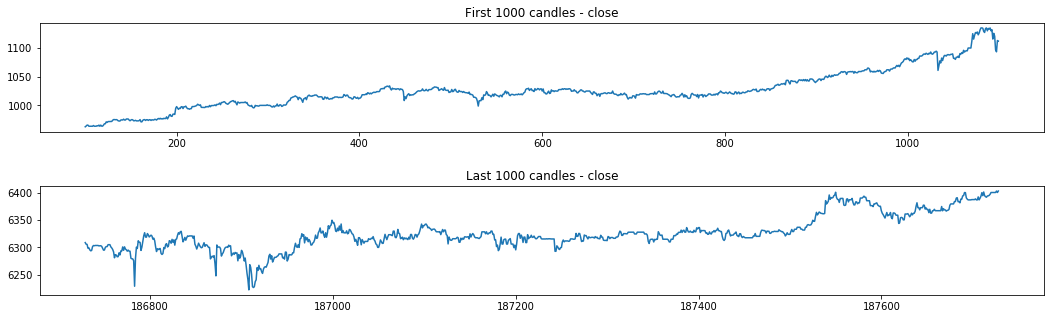

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# data = np.genfromtxt('poloniex_usdt_btc_20170101_DOHLCV_300.csv', delimiter=';', skip_header=1)

# Visualizing chart with close prices
# These charts are ok
plt.figure(figsize=(18, 5))
plt.subplot(211).set_title('First 1000 candles - close')
plt.plot(df.iloc[:1000, 4])
plt.subplot(212).set_title('Last 1000 candles - close')
plt.plot(df.iloc[-1000:, 4])
plt.subplots_adjust(hspace=0.5)
plt.show()


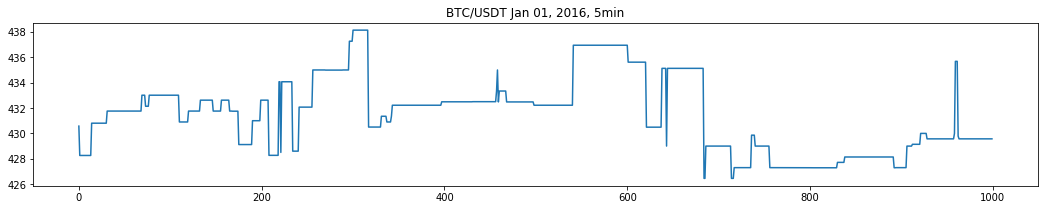

In [6]:
# Reason why we decided to use data from 2017:
# Chart from Jan, 2016 has flat parts because of low volume

# 5min BTC/USDT chart form Poloniex from Jan 01, 2016
with urllib.request.urlopen("https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451606400&end=1454284800&period=300") as url:
    wrong_data = json.loads(url.read().decode())
    
wrong_close = []
for line in wrong_data:
    wrong_close.append(line['close'])

plt.figure(figsize=(18, 3))
plt.plot(wrong_close[:1000])
plt.title('BTC/USDT Jan 01, 2016, 5min')
plt.show()

In [7]:
print(df.head(20))

           date        open        high         low       close       volume
100  1483258800  965.615287  965.615287  962.720039  962.720050   339.976571
101  1483259100  965.615288  965.615288  963.715702  964.000000  2053.800108
102  1483259400  965.584776  965.584776  963.669103  965.584776    26.914038
103  1483259700  963.669114  965.584775  963.669114  965.584775   405.889147
104  1483260000  963.669121  963.669121  963.669121  963.669121    30.485711
105  1483260300  963.669121  963.669121  963.669121  963.669121    19.273382
106  1483260600  963.669121  965.160002  963.669121  963.769121    81.704008
107  1483260900  963.769121  963.769121  963.769121  963.769121     1.704127
108  1483261200  963.769121  963.769121  963.669121  963.669121  1818.413816
109  1483261500  963.669121  965.160002  963.669121  964.878418   274.672493
110  1483261800  964.673318  965.123774  963.669121  963.669122  2358.067209
111  1483262100  964.826366  965.118433  963.718773  963.718779   185.801106

In [8]:
# Turn dataframe into a numpy floating point array
df_values = df.values
timestamps = df_values[:, 0]
dataset = df_values[:, 1:].astype("float")

# Ignore the first 20 row, because we are using SMA on 20 samples,
# so these incosistent values values
dataset = dataset[20:, :]


# Split the dataset into training (70%), cross validation (20%) and test (10%) set
samples_num = dataset.shape[0]

valid_split = 0.2
test_split = 0.1

dataset_train = dataset[0:int(samples_num * (1 - valid_split - test_split))]
dataset_valid = dataset[int(samples_num * (1 - valid_split - test_split)):int(samples_num * (1 - test_split))]
dataset_test = dataset[int(samples_num * (1 - test_split)):]

# Helper function for creating dataset for LSTM components
# [Description:   We want to predict the next value in time, so we have to
#                 shift the values with the 'look_back' variable]
def create_dataset_for_lstm(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

# Call the helper function for the training, cross validation and test sets,
# then format them consistently
look_back = 1
X_train, Y_train = create_dataset_for_lstm(dataset_train, look_back)
X_valid, Y_valid = create_dataset_for_lstm(dataset_valid, look_back)
X_test, Y_test = create_dataset_for_lstm(dataset_test, look_back)

X_train = X_train[:, 0, :]
X_valid = X_valid[:, 0, :]
X_test = X_test[:, 0, :]

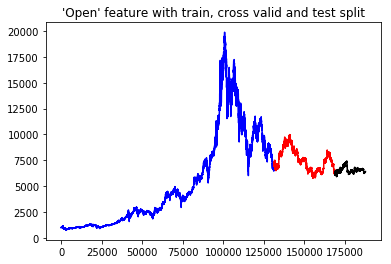

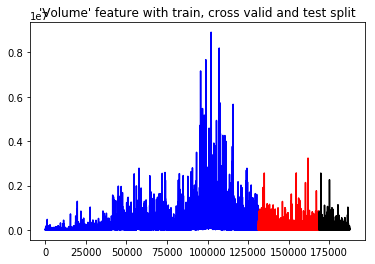

IndexError: index 5 is out of bounds for axis 1 with size 5

In [9]:
# Plot 'open' feature
plt.plot(dataset_train[:, 0], '-b')
plt.plot([None for i in dataset_train[:, 0]] + [x for x in dataset_valid[:, 0]], '-r')
plt.plot([None for i in dataset_train[:, 0]] + [None for x in dataset_valid[:, 0]] + [x for x in dataset_test[:, 0]], '-k')
plt.title("'Open' feature with train, cross valid and test split")
plt.show()

# Plot 'volume' feature
plt.plot(dataset_train[:, 4], '-b')
plt.plot([None for i in dataset_train[:, 4]] + [x for x in dataset_valid[:, 4]], '-r')
plt.plot([None for i in dataset_train[:, 4]] + [None for x in dataset_valid[:, 4]] + [x for x in dataset_test[:, 4]], '-k')
plt.title("'Volume' feature with train, cross valid and test split")
plt.show()

# Plot 'sma' feature
plt.plot(dataset_train[:, 5], '-b')
plt.plot([None for i in dataset_train[:, 5]] + [x for x in dataset_valid[:, 5]], '-r')
plt.plot([None for i in dataset_train[:, 5]] + [None for x in dataset_valid[:, 5]] + [x for x in dataset_test[:, 5]], '-k')
plt.title("'SMA' feature with train, cross valid and test split")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print ("X_train:\n" + str(X_train))
print ("\nX_valid:\n" + str(X_valid))
print ("\nX_test:\n" + str(X_test))